# Libraires

In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.test.is_built_with_cuda():
    print("TensorFlow was built with CUDA")
else:
    print("TensorFlow was not built with CUDA")



Num GPUs Available:  0
TensorFlow was not built with CUDA


In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import PassiveAggressiveClassifier #used to train the model
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, confusion_matrix, roc_auc_score, roc_curve # this is used to evaluate the model.
from sklearn.model_selection import train_test_split # to separate the dataset.
from sklearn.feature_extraction.text import TfidfVectorizer #used for the transformation of text data.
import pickle as pkl #file to save and load a model.
from sklearn.model_selection import GridSearchCV #pour l'optimisation des hyperparametres.
import time #pour étudier le temps d'execution d'entrainement, de notre meilleure modèle.
import psutil #pour calculer la mémoire.
import os #pour calculer le temps d'execution.
import joblib


# Load Data

In [3]:
data=pd.read_csv('title_text.csv').drop(['Unnamed: 0'],axis=1)

In [4]:
data

,title,text,isFake
0,Nancy Pelosi Backs BOMBSHELL Legislation That...,Donald Trump hasn t even been president for a ...,True
1,Ukraine prosecutor says puzzled by lack of U.S...,KIEV (Reuters) - Ukraine is puzzled by the lac...,False
2,Trump nominates businessman with Asia backgrou...,WASHINGTON (Reuters) - U.S. President Donald T...,False
3,Zimbabwe's Mnangagwa opens amnesty window for ...,"HARARE (Reuters) - Zimbabwe s new president, E...",False
4,OBAMA’S COMMUNIST ENVIRONMENTAL ARM Tells Kids...,Our children don t need the EPA to tell them h...,True
...,...,...,...
42821,RBG BLASTS Republicans For Crippling The Supr...,Supreme Court Justice Ruth Bader Ginsburg is b...,True
42822,Sanders Campaign Withdraws Lawsuit Against DN...,"You might remember a few months ago, the Berni...",True
42823,WATCH: Bernie Sanders Invokes Holocaust To De...,Bernie Sanders is not one to mince words when ...,True
42824,INSIDE TRUMP’S CHARITY BALL Tonight At Beautif...,Trump on immigration appeal: We ll win. For t...,True


In [5]:
#we make everything lower.
data['text']=data['text'].apply(lambda x: x.lower())
data

,title,text,isFake
0,Nancy Pelosi Backs BOMBSHELL Legislation That...,donald trump hasn t even been president for a ...,True
1,Ukraine prosecutor says puzzled by lack of U.S...,kiev (reuters) - ukraine is puzzled by the lac...,False
2,Trump nominates businessman with Asia backgrou...,washington (reuters) - u.s. president donald t...,False
3,Zimbabwe's Mnangagwa opens amnesty window for ...,"harare (reuters) - zimbabwe s new president, e...",False
4,OBAMA’S COMMUNIST ENVIRONMENTAL ARM Tells Kids...,our children don t need the epa to tell them h...,True
...,...,...,...
42821,RBG BLASTS Republicans For Crippling The Supr...,supreme court justice ruth bader ginsburg is b...,True
42822,Sanders Campaign Withdraws Lawsuit Against DN...,"you might remember a few months ago, the berni...",True
42823,WATCH: Bernie Sanders Invokes Holocaust To De...,bernie sanders is not one to mince words when ...,True
42824,INSIDE TRUMP’S CHARITY BALL Tonight At Beautif...,trump on immigration appeal: we ll win. for t...,True


# Modification du text en données numériques.
Nous partons du principe que les données ont étés clean et que nous pouvons nous concerntrer à créer un model.

Comme les informations principales pour définir des Fake news et des vrai news, se base sur le texte et le titre, nous devons nous focaliser sur ces informations. Il faut ainsi que nous transformons le text et le titre en données afin que notre model puisse utiliser des données numériques pour trouver la bonne réponse. Nous allons utiliser la methode de TF-IDF vectorizing.

### TF-IDF vectorizer
Cette méthode offre la possibilité de déterminer les scores TF-IDF de nos données textuelles. Ce qui signifie : 

TF -> la Fréquence du Terme : le nombre de fois qu'un mot apparaît, en éliminant les mots qui ne sont pas importants.

IDF -> la fréquence inverse de détection : le même concept que TF, mais l'analyse va au-delà de la simple ligne, la fréquence dans l'ensemble du dataset est analysée.

Ces informations seront utilisées comme données pour notre modèle d'apprentissage automatique.

(il est important de faire cela uniquement sur nos données d'entraînement, sinon le modèle connaîtra les données de test)

In [6]:
tfidf_filename='tfidf_vectorizer.pkl'

In [7]:
X=data.drop(['isFake'],axis=1)
y=data['isFake']
#spearation en données d'entrainement et de test.
X_train, X_test, y_train, y_test = train_test_split(X['text'], y, test_size=0.2, random_state=42)

tfidf_vectorizer=TfidfVectorizer(use_idf=True)

# On fit et transforme les données d'entrainement.
tfidf_train=tfidf_vectorizer.fit_transform(X_train).toarray()

# on transfomer uniquement le test set, sinon il va connaitre les données test...
tfidf_test=tfidf_vectorizer.transform(X_test)

joblib.dump(tfidf_vectorizer, tfidf_filename) #on stoque le vectorizer dans un fichier pour le reutiliser plus tard.

['tfidf_vectorizer.pkl']

In [8]:
X_train.shape

(34260,)

In [9]:
tfidf_train.shape

(34260, 108400)

In [10]:
X_test.shape,y_test.shape

((8566,), (8566,))

# Model Passive Agressive

Quand on parle d'un model passive aggressive, nous parlons d'un algorithme linéaire de classification et de regression. C'est un algorithme d'apprentissage en ligne, Il traite les données séquentiellement, ajustant le prédicteur à chaque nouvelle instance pour améliorer la prédiction future.

Le modèle se base sur deux principes:
- **Passive**: Si notre modèle prédit une instance juste, alors les poids et les biais ne seront pas changés. L'état actuelle de notre modèle sera maintenu.
- **Aggressive**: Si notre modèle fait une mauvaise prédiction sur une instance ressus, les poids et biais de notre modèle seront changés par le paramètre de régularisation **C**, le but étant de minimiser l'erreur. Il change les paramètres pour que la prédiction actuelle soit 'just'.

Le modèle utilise par défaut la fonction de cout **hinge**. Voici comment mathématiquement les poids et bias seront changés:

$$ w_{\text{new}} = w + \alpha y x $$
$$ b_{\text{new}} = b + \alpha y $$

où **w** est le vecteur de poids, **b** est le biais, **x** est le vecteur de caractéristiques de l'instance mal classée, **y** est l'étiquette correcte de l'instance, et **α** est le taux d'apprentissage calculé en fonction de l'erreur et du paramètre de régularisation **C**

Comme nous traitons des données de texte, et que nous devons faire une classification binaire, il ce va de dire que les text vont avoir des pattern differents, en utilisant le model passive aggressive, nous pouvons entrainer le model à définir une méthode pour les idenfifier.

In [11]:
# we build our model: C is the regulation parameter, and denotes the penalization the model will make on an incorrect prediciton.
model = PassiveAggressiveClassifier(C = 0.2, 
                                    random_state = 42,
                                    early_stopping=True,# we enable the early stopping procedure.
                                    n_iter_no_change=3, #number of iterations before early stopping
                                    verbose=True,
                                    loss='hinge', #fonction de cout
                                   )


In [12]:
filenm = 'PassiveAggressiveClassifier_model.pickle'

In [13]:
#on entraine le model sur les données d'entrainement.
model.fit(tfidf_train,y_train)
#Create or open a file with write-binary mode and save the model to it
pickle = pkl.dump(model, open(filenm, 'wb'))

-- Epoch 1
Norm: 37.85, NNZs: 54809, Bias: 1.446771, T: 30421, Avg. loss: 0.113609
Total training time: 62.92 seconds.
-- Epoch 2
Norm: 44.85, NNZs: 55928, Bias: 0.582384, T: 60842, Avg. loss: 0.039183
Total training time: 177.66 seconds.
-- Epoch 3
Norm: 49.44, NNZs: 56391, Bias: 0.774031, T: 91263, Avg. loss: 0.025336
Total training time: 295.99 seconds.
-- Epoch 4
Norm: 52.86, NNZs: 56584, Bias: 0.943099, T: 121684, Avg. loss: 0.018095
Total training time: 416.61 seconds.
Convergence after 4 epochs took 474.54 seconds


In [14]:
#on sort les predictions
#Step 2: Open the saved file with read-binary mode
model = pkl.load(open(filenm, 'rb'))
y_pred=model.predict(tfidf_test)

# Optimisation

Pour optimiser le model nous allons modifier les paramètres suivants:
- **C (Le paramètre de régularisation)**: Un des paramètres les plus importants de l'algorithme passive aggressive. Il est utilisé pour controler la marge d'erreur que notre modèle est près à accepté. Si on lui donne une valeur de plus en plus élevé il se peut que le modèle suraprenne, car il s'adapte mieux aux données d'entrainement. Ainsi une valeur plus faible serait favorable. Nous allons tester C avec les valeurs suivantes: **[0.01,0.05,0.1,0.5,1]**

In [15]:
params_grid={'C':[0.01,0.05,0.1,0.5,1]}

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import make_scorer, accuracy_score


# Initialize the Passive Aggressive Classifier
model = PassiveAggressiveClassifier(random_state=42,early_stopping=True)

# On creer un scorer pour le grid search 
scorer = make_scorer(accuracy_score)

# Initialisation de la GridSearch pour trouver le meilleur C.
grid_search = GridSearchCV(estimator=model, param_grid=params_grid, scoring=scorer, cv=5)

# On lance les multiples entrainements.
grid_search.fit(tfidf_train, y_train)


GridSearchCV(cv=5,
             estimator=PassiveAggressiveClassifier(early_stopping=True,
                                                   random_state=42),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1]},
             scoring=make_scorer(accuracy_score))

In [17]:
# Get the best combination of parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")


Best parameters: {'C': 0.5}
Best score: 0.9927904261529481


# Model Evaluation

Afin d'évaluer le modèle nous faisons une représentation graphique des résultats obtenus. Nous allons étudier les metrics suivants:
- le **temps d'entrainement** que le modèle a besoin, ainsi que son **taux de mémoire (Mo)**.
- **matrice de confusion**, qui est un excellent choix d'évaluation de performance, car nous sommes dans le cas d'une classification binaire. 
- **L'accuracy** du model.
- **La précision**
- **recall**
- **F1-score**.
- **ROC-AUC score**

src: https://www.v7labs.com/blog/performance-metrics-in-machine-learning#h2

In [18]:
#creation du modèle avec les meilleurs paramètres
best_model=PassiveAggressiveClassifier(C=best_params['C'],
                                       early_stopping=True,
                                       verbose=True,
                                       random_state=42)

Nous voullons étudier **le temps d'entrainement (en h/m/s)** et **l'utilisation de la mémoire (Mo)** que le modèle a besoin.

In [19]:
def second_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return int(hours), int(minutes), int(seconds)

def bytes_to_Mo(mem_bytes):
    mem_kb = mem_bytes / 1024  # Convertir en kilooctets
    mem_mb = mem_kb / 1024  # Convertir en mégaoctets
    return mem_mb

In [20]:
#lancemenet de l'enrestristrement de la mémoire.
process = psutil.Process(os.getpid())
mem_before_bytes = process.memory_info().rss

#lancement de l'enregistrement du temps d'entrainement.
start_time = time.time() 
# entrainement du modèle.
best_model.fit(tfidf_train,y_train)
end_time = time.time()

#le temps écoulé 
elapsed_time= end_time - start_time

print(f"Temps d'entrainement (h | m | s) : {second_to_hms(elapsed_time)[0]} | {second_to_hms(elapsed_time)[1]} | {second_to_hms(elapsed_time)[2]}")

mem_after_bytes = process.memory_info().rss
#on convertit les bytes en Mo.
mem_bytes=mem_after_bytes - mem_before_bytes


print(f"Utilisation de la mémoire (Mo) : {bytes_to_Mo(mem_bytes)}")

-- Epoch 1
Norm: 50.22, NNZs: 48221, Bias: 0.754457, T: 30423, Avg. loss: 0.089139
Total training time: 56.06 seconds.
-- Epoch 2
Norm: 58.42, NNZs: 50076, Bias: 1.323730, T: 60846, Avg. loss: 0.026460
Total training time: 159.38 seconds.
-- Epoch 3
Norm: 63.03, NNZs: 50939, Bias: 0.978222, T: 91269, Avg. loss: 0.014987
Total training time: 272.56 seconds.
-- Epoch 4
Norm: 66.19, NNZs: 51376, Bias: 1.427957, T: 121692, Avg. loss: 0.009891
Total training time: 376.06 seconds.
-- Epoch 5
Norm: 68.04, NNZs: 51616, Bias: 0.667627, T: 152115, Avg. loss: 0.006047
Total training time: 485.90 seconds.
-- Epoch 6
Norm: 69.45, NNZs: 51704, Bias: 1.090323, T: 182538, Avg. loss: 0.004447
Total training time: 593.12 seconds.
Convergence after 6 epochs took 643.31 seconds
Temps d'entrainement (h | m | s) : 0 | 11 | 34
Utilisation de la mémoire (Mo) : -85.6640625


In [21]:
#Create or open a file with write-binary mode and save the model to it
pickle = pkl.dump(best_model, open(filenm, 'wb'))

In [22]:
#optention des prédictions de ce modèle.
y_pred=best_model.predict(tfidf_test)

Nous déterminons la **matrice de confusion**.

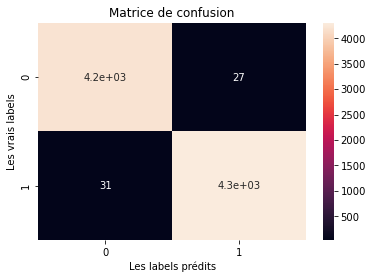

In [23]:
#creation de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

#représentation graphique du résultat du meilleure model
sns.heatmap(cm, annot=True)
plt.xlabel('Les labels prédits')
plt.ylabel('Les vrais labels')
plt.title('Matrice de confusion')
plt.show()

In [24]:
print(f"le modèle a donc {cm[0][0]} instances vrai Positives et {cm[1][1]} instances de Vrai négatives, {cm[1][0]} instances de Faux Positives et {cm[0][1]} instances de Faux négatives. ")

le modèle a donc 4204 instances vrai Positives et 4304 instances de Vrai négatives, 31 instances de Faux Positives et 27 instances de Faux négatives. 


Nous allons avant tout calculer **la précision globale (accuracy)** de notre modèle. 

In [25]:
acc=accuracy_score(y_pred,y_test)
print(f"Notre modèle a une précision globale de {round(acc*100,2)}%, ce qui signifie qu'il prédit correctement les classes des instances dans {round(acc*100,2)}% des cas.")

Notre modèle a une précision globale de 99.32%, ce qui signifie qu'il prédit correctement les classes des instances dans 99.32% des cas.


on calcul le **precision**, c'est la capacité du modèle à correctement identifier les instances que nous avons prédits. Donc de prédire qu'une News vrai soit vraie.

In [26]:
precision=precision_score(y_test,y_pred)
print(f"notre model a une precision de {round(precision*100,2)}% . lorsqu'il prédit une classe comme positive, il a raison dans {round(precision*100,2)}% des cas.")

notre model a une precision de 99.38% . lorsqu'il prédit une classe comme positive, il a raison dans 99.38% des cas.


on calcul le **recall**, ce qui es le pourcentage de Vrai positif **(dans notre cas les Vrai news)** que notre modèle arrive à prédire.

In [27]:
recall=recall_score(y_test,y_pred)
print(f"notre model arrive a détecter {round(recall*100,2)}%. Donc sur l'ensemble des vrai positives, le modèle parvient à en identifier correctement {round(recall*100,2)}% des cas.")

notre model arrive a détecter 99.28%. Donc sur l'ensemble des vrai positives, le modèle parvient à en identifier correctement 99.28% des cas.


On calcule le **F1-score**, c'est une combinaison de la précision et du recall, en calculant la moyenne harmonique entre les deux. Son but est **d'étudier l'équilibre entre la precision et le recall.**

In [28]:
f1score=f1_score(y_test,y_pred)
print(f"notre model a un F1-score de {round(f1score*100,2)}%, ce qui signifie que il y a un excellent equilibre entre le recall et la précision.")

notre model a un F1-score de 99.33%, ce qui signifie que il y a un excellent equilibre entre le recall et la précision.


## Courbe ROC-AUC
Dans le contexte d'une classification binaire, il est essentiel d'utiliser la courbe ROC-AUC pour évaluer notre modèle. Nous allons examiner deux aspects :

- **ROC (Receiver Operating Characteristic)**: Cette courbe illustre le rapport entre le taux de vrais positifs et le taux de faux positifs. Elle permet de visualiser la capacité du modèle à discriminer entre les deux classes.

- **AUC (Area Under the Curve)**: C'est une mesure qui résume la courbe ROC en calculant l'aire sous celle-ci et au-dessus de la diagonale qui va du coin inférieur gauche au coin supérieur droit du graphique. Un score AUC proche de 1 indique que notre modèle fait des prédictions presque parfaites. En revanche, un score proche de 0,5 suggère que nos prédictions sont principalement due au hasard, ce qui signifie que le modèle n'apprend pas de manière efficace.

L'objectif de ces mesures est de déterminer à quel point notre modèle est efficace dans la tâche de classification binaire.

On définit le score ROC-AUC.

In [29]:
roc_auc=roc_auc_score(y_test,y_pred)
roc_auc

0.9932337170829793

In [30]:
print(f"Le modèle a donc une score ROC-AUC de {roc_auc} ce qui est très proche de 1, donc le modèle a une excellente capacité à différencier entres les Fake et les vrais news.")

Le modèle a donc une score ROC-AUC de 0.9932337170829793 ce qui est très proche de 1, donc le modèle a une excellente capacité à différencier entres les Fake et les vrais news.


Avec une valeur aussi élevée, nous pouvons être confiants dans le fait que notre modèle est extrêmement précis et fiable pour notre tâche de classification, avec très peu de faux positifs et de faux négatifs. Cela indique que notre modèle fait des erreurs de prédiction minimales. Nous allons maintenant procéder à la représentation graphique de la courbe ROC-AUC.

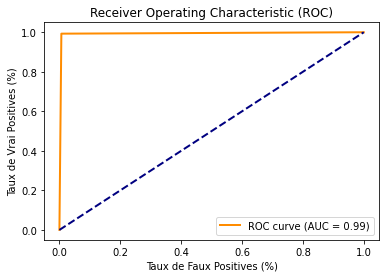

In [31]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de Faux Positives (%)')
plt.ylabel('Taux de Vrai Positives (%)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

L'axe des abscisses (axe x) représente le taux de faux positifs, c'est-à-dire le pourcentage de vraies nouvelles que notre modèle a incorrectement classifiées comme fausses (Fake News).

L'axe des ordonnées (axe y) indique le taux de vrais positifs, qui correspond au pourcentage de fausses nouvelles que notre modèle a correctement identifiées comme telles.

La courbe montante vers le coin supérieur gauche du graphique suggère que le modèle parvient à maintenir un taux élevé de vrais positifs tout en minimisant le taux de faux positifs, ce qui est le comportement idéal pour un classificateur. 
Cette représentation représente la robustesse du mdoèle.

# Test de performances sur des données générées par Téléchargé ailleurs

In [9]:
filenm = 'PassiveAggressiveClassifier_model.pickle'
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
best_model=pkl.load(open(filenm, 'rb'))

C:\Users\MIKED\miniconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 0.23.1 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\MIKED\miniconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 0.23.1 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\MIKED\miniconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PassiveAggressiveClassifier from version 0.23.1 when using version 

In [10]:
validation_data=pd.read_csv("data/validation_data.csv")
validation_data.head()

,Unnamed: 0,text,isFake
0,0,"Daniel Greenfield, a Shillman Journalism Fello...",False
1,1,Google Pinterest Digg Linkedin Reddit Stumbleu...,False
2,2,U.S. Secretary of State John F. Kerry said Mon...,True
3,3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",False
4,4,It's primary day in New York and front-runners...,True


In [11]:
validation_data=validation_data[['text','isFake']]
validation_data

,text,isFake
0,"Daniel Greenfield, a Shillman Journalism Fello...",False
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,False
2,U.S. Secretary of State John F. Kerry said Mon...,True
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",False
4,It's primary day in New York and front-runners...,True
...,...,...
6330,The State Department told the Republican Natio...,True
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,False
6332,Anti-Trump Protesters Are Tools of the Oligar...,False
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",True


In [12]:
# Prepare the data
validation_data_X = validation_data['text'].apply(lambda x: x.lower())  # the text data
validation_data_y=validation_data['isFake']

# Transform the data using the TF-IDF Vectorizer
X_tfidf = tfidf_vectorizer.transform(validation_data_X)

# Use the trained model to make predictions on the dataset
predictions = best_model.predict(X_tfidf)

In [13]:
confusion_matrix(validation_data_y,predictions)

array([[ 217, 2947],
       [ 791, 2380]], dtype=int64)

In [15]:
accuracy_score(validation_data_y,predictions)

0.40994475138121544

# Conclusion

les évaluations et analyses approfondies de notre modèle confirment qu'il est extrêmement efficace et fiable pour l'identification des fake news. Ses performances élevées sur plusieurs métriques clés (accuracy,precision,recall,F1-score et ROC-AUC) démontrent sa capacité à fournir des prédictions précises et équilibrées, confortant notre choix d'utiliser ce modèle pour cette tache.